# Reinforcement Learning Individual Assignment 

Student name: Victor Girou

## Import and dependencies

In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\victo\appdata\local\temp\pip-req-build-x_qhc3if
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\victo\AppData\Local\Temp\pip-req-build-x_qhc3if'


## 0. Utility functions and Import

Let's first some usefull function that agent will use for training or the readrer will use to plot results.

In [2]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict

import text_flappy_bird_gym
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode following the epsilon-greedy policy 
    :param env: gym like environment
    :param Q: dictionary of the Q value function, keys must be string of the observation
    :param epsilon: exploration  parameter
    :param nA: int, number of possible actions
    """
    episode = []
    state = env.reset()
    state = state[0] #remove useless information
    while True:
        # espilon greedy action prediction 
        if str(state) in list(Q.keys()):
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[str(state)])
        else:
            action = env.action_space.sample()
            Q[str(state)] = np.zeros(nA)

        # take a step in the environement
        next_state, reward, done, _, info = env.step(action)
        episode.append((str(state), action, reward))
        state = next_state
        if done:
            break
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] += alpha * (np.sum(discounts[:-(i+1)] * rewards[i:]) - old_Q)
    return Q


def moving_average(vector, window_size):
    '''
    Moving average too smooth function
    '''

    mvg_average = np.zeros(len(vector))

    for i in range(len(vector)):

        mvg_average[i] = np.mean(vector[max(0, i - window_size): min(i + window_size, len(vector))])
    
    return mvg_average

def get_state_from_str(obs: str):

    obs_splitted = obs[1:-1].split(',')

    return int(obs_splitted[0]), int(obs_splitted[1])

In [41]:
def plot_state_value_function(Q, model:str, view='3D'):
    V = dict((k, np.max(val)) for k, val in Q.items())

    x = np.array([get_state_from_str(k)[0] for k in V.keys()])
    y = np.array([get_state_from_str(k)[1] for k in V.keys()])
    z = np.array([[val] for val in V.values()])  # Remove unnecessary nested list

    X = np.unique(x)
    Y = np.unique(y)

    if model=='sarsa':
        Z = np.ones((len(Y), len(X)))
    else:
        Z = np.zeros((len(Y), len(X)))
    # fill values in state value matrix
    for idx_y, coord_y in enumerate(Y):
        for idx_x, coord_x in enumerate(X):

            if '(' + str(coord_x) + ', ' + str(coord_y) + ')' in list(V.keys()):

                Z[idx_y, idx_x] = V['(' + str(coord_x) + ', ' + str(coord_y) + ')']

    

    # Create meshgrid for 3D plot
    X, Y = np.meshgrid(X, Y)

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if view=='2D':
        ax.view_init(elev=90, azim=-90)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, )

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('V(s)')
    ax.set_title('State Value Function V(s)')


    # Show plot
    plt.show()

## 1. Monte Carlo based agent

### 1.1 Agent implementation

In [12]:
def mc_control(env, num_episodes, alpha, gamma=1.0, epsilon=0.1):
    nA = env.action_space.n
    rewards = []

    # initialize empty dictionary of arrays
    Q = {}
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   

        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        rewards.append(np.sum([e[2] for e in episode]))

        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())

    return policy, Q, rewards

In [6]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

### 1.2 Hyper-parameters optimization

In [47]:
policies_mc = {}
Q_values_mc = {}
rewards_mc = {}

# run experiment for different values
for alpha in [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]:
    for gamma in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]:

        policies_mc[str((alpha, gamma))], Q_values_mc[str((alpha, gamma))], rewards_mc[str((alpha, gamma))] = mc_control(env, 10000, alpha, gamma=gamma)

Episode 10000/10000.

In [56]:
# determine the optimal parameters
alpha_opt = 0
gamm_opt = 0
R_max = 0
for param, r in rewards_mc.items():
    if np.max(moving_average(r, 600))> R_max:
        R_max = np.max(moving_average(r, 600))
        alpha_opt = param
  

In [57]:
R_max

100.29916666666666

In [60]:
alpha_opt

'(0.1, 0.9)'

In [37]:
policy_mc, Q_mc, rewards_mc_list = mc_control(env, 10000, 0.1, gamma=0.9)

Episode 10000/10000.

### 1.3 Evaluation

In [38]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
cum_R = []
scores = []

for e in range(100):
    obs = env.reset()[0]
    t = 0
    R = []
    done = False
    # iterate
    while True:

        # Select next action
        if str(obs) in policy_mc.keys():
            
            action = policy_mc[str(obs)]  # for an agent, action = agent.policy(observation)
        else:
            action = env.action_space.sample()
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)
        R.append(reward)
        env.render()

        # If player is dead break
        if done:
            break

        t+=1

        if t >= 1000:
            break
    cum_R.append(np.sum(R))
    scores.append(info['score'])
    env.close()

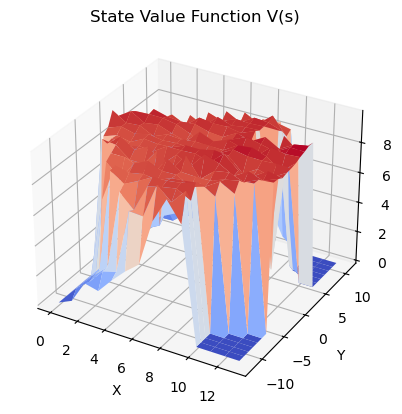

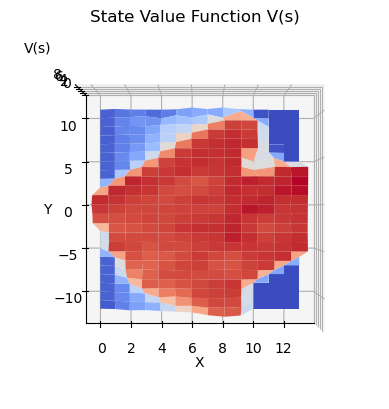

In [42]:
plot_state_value_function(Q_mc, 'mc')
plot_state_value_function(Q_mc, 'mc', view='2D')

## 2. Sarsa($\lambda$)

Now we will implement the algorithm Sarsa($\lambda$) introduced in Section 12.7 in  Sutton and Barto

### 2.1 Implementation

In [35]:
def sarsa_lambda(env, num_episodes, alpha, lambda_, gamma=1, epsilon=0.1):

    n_actions = env.action_space.n
    
    # initialize empty dictionary of arrays for Q and Eligibility Trace
    Q = defaultdict(lambda: np.ones(n_actions))
    E = defaultdict(lambda: np.zeros(n_actions))
    rewards = []

    for episode in range(1, num_episodes+1):

        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()

        obs = env.reset()
        obs = obs[0]
        done = False
        cum_reward = 0

        # Select first action with epsilon greedy policy

        if str(obs) in list(Q.keys()):

            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[str(obs)])
        else:
            action = env.action_space.sample()
            Q[str(obs)] = np.zeros(n_actions)

        while True:
            
            next_obs, reward, done, _, info = env.step(action)

            if str(next_obs) in list(Q.keys()):

                if np.random.uniform() < epsilon:
                    next_action = env.action_space.sample()
                else:
                    next_action = np.argmax(Q[str(next_obs)])
                
            else:
                next_action = env.action_space.sample()
                Q[str(next_obs)] = np.zeros(n_actions)
                
            q_val = Q[str(obs)][action]
            next_q_val = (not done) * Q[str(next_obs)][next_action]
            delta = reward + gamma * next_q_val - q_val
            cum_reward += reward

            E[str(obs)][action] += 1

            # update Q values and Eligibility
            for o in list(Q.keys()):

                Q[o][:] += alpha * delta * E[o][:]
                E[o][:] = gamma*lambda_*E[o][:]
            
            obs = next_obs
            action = next_action

            if done:
                break

        rewards.append(cum_reward)
            
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards

### 2.2 Training

In [36]:
policy_sarsa, Q_sarsa, rewards_sarsa = sarsa_lambda(env, 10000, alpha=0.2, lambda_=0.9 gamma=0.9)

TypeError: sarsa_lambda() got an unexpected keyword argument 'max_timestep'

### 2.3 Evaluation

Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action !!!!!!
Random action

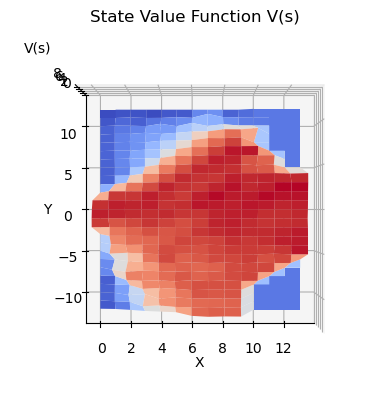

In [75]:
plot_state_value_function(Q_sarsa, 'sarsa')
plot_state_value_function(Q_sarsa, 'sarsa', view='2D')

## 3. Agent comparison

Text(0, 0.5, 'Averaged cumulative reward')

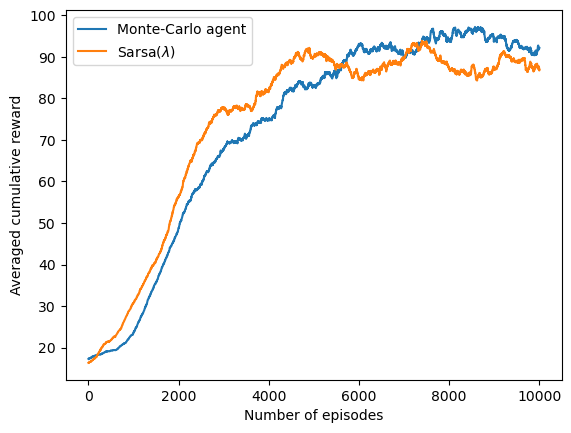

In [62]:
plt.plot(np.arange(len(rewards_mc_list)), moving_average(rewards_mc_list, 600), label='Monte-Carlo agent')
plt.plot(np.arange(len(rewards_sarsa)), moving_average(rewards_sarsa, 600), label='Sarsa($\lambda$)')
plt.legend()
plt.xlabel('Number of episodes')
plt.ylabel('Averaged cumulative reward')

## 4. Sensitivity to parameters

## 4.1 Exploration vs Exploitation

In this part will be investigated the influence of exploration on training. This influence will first be studied on the MC based agent.

In [13]:
# define epsilon values
influence_epsilon = {}
epsilon_values = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

for eps in epsilon_values:

    influence_epsilon[eps] = mc_control(env, 10000, alpha=0.1, gamma=0.9, epsilon=eps)

Episode 10000/10000.

Now the moving average of the cumulative rewards can be displayed:

Text(0.5, 1.0, 'MC based agent Exploitation vs Exploration')

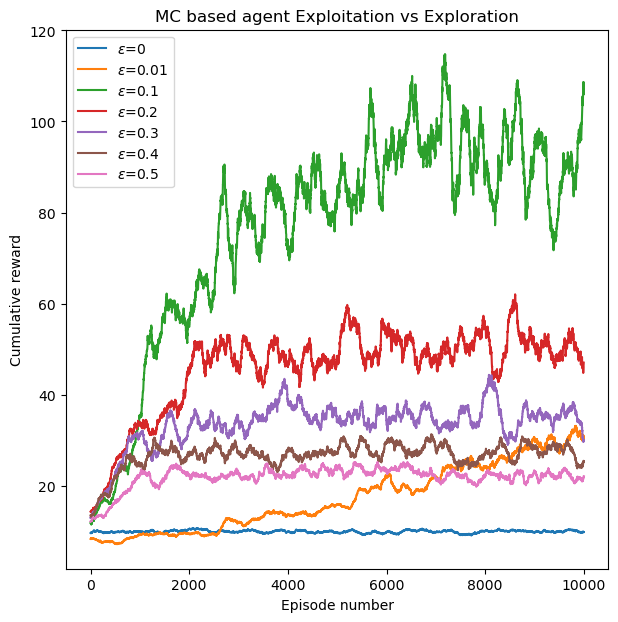

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for eps in epsilon_values:

    ax.plot(moving_average(influence_epsilon[eps][2], window_size=100), label='$\epsilon$={}'.format(eps))
ax.legend()
ax.set_xlabel('Episode number')
ax.set_ylabel('Cumulative reward')
ax.set_title('MC based agent Exploitation vs Exploration')

Now let's evaluate the influence on the Sarsa($\lambda$) agent. As highligthed during our study, convergence speed of Sarsa($\lambda$) is higher than MC Control. We will use less steps for this study of the influence of epsilon.

In [43]:
# define epsilon values
influence_epsilon = {}
epsilon_values = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

for eps in epsilon_values:

    influence_epsilon[eps] = sarsa_lambda(env, 2000, alpha=0.2, lambda_=0.9, gamma=0.9)

Episode 2000/2000.

Text(0.5, 1.0, 'Sarsa($\\lambda$) agent Exploitation vs Exploration')

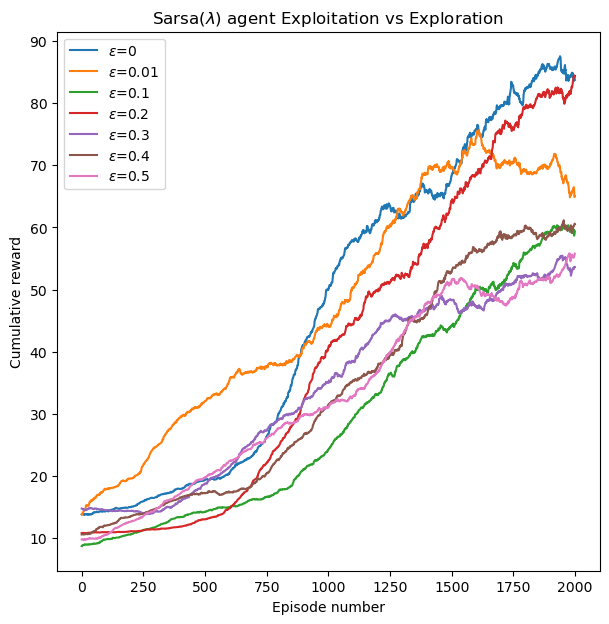

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for eps in epsilon_values:

    ax.plot(moving_average(influence_epsilon[eps][2], window_size=200), label='$\epsilon$={}'.format(eps))
ax.legend()
ax.set_xlabel('Episode number')
ax.set_ylabel('Cumulative reward')
ax.set_title('Sarsa($\lambda$) agent Exploitation vs Exploration')

### 4.2 Robustness to modification in the environment

#### 4.2.1 Monte-Carlo based agent

In [ ]:
widths = np.arange(15, 30)

results_width_influence_mc = {}
for w in widths:
    env = gym.make('TextFlappyBird-v0', height=15, width=w, pipe_gap=4)
    cum_R = []
    scores = []

    for e in range(100):
        obs = env.reset()[0]
        t = 0
        R = []
        done = False
        # iterate
        while True:

            # Select next action
            if str(obs) in policy_mc.keys():
                action = policy_mc[str(obs)]  # for an agent, action = agent.policy(observation)
            else:
                action = env.action_space.sample()
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            R.append(reward)

            # If player is dead break
            if done:
                break
            t+=1

            if t >= 1000:
                break
        cum_R.append(np.sum(R))
        scores.append(info['score'])
    results_width_influence_mc[w] = [np.mean(cum_R), np.mean(scores)]

plt.plot(widths, [r[0] for r in results_width_influence_mc.values()])
plt.xlabel('Width')
plt.ylabel('Mean cumulative reward')


In [ ]:
widths = np.arange(10, 30)

results_height_influence_mc = {}
for w in widths:
    env = gym.make('TextFlappyBird-v0', height=h, width=20, pipe_gap=4)
    cum_R = []
    scores = []

    for e in range(100):
        obs = env.reset()[0]
        t = 0
        R = []
        done = False
        # iterate
        while True:

            # Select next action
            if str(obs) in policy_mc.keys():
                action = policy_mc[str(obs)]  # for an agent, action = agent.policy(observation)
            else:
                action = env.action_space.sample()
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            R.append(reward)

            # If player is dead break
            if done:
                break
            t+=1

            if t >= 1000:
                break
        cum_R.append(np.sum(R))
        scores.append(info['score'])
    results_height_influence_mc[w] = [np.mean(cum_R), np.mean(scores)]

plt.plot(widths, [r[0] for r in results_height_influence_mc.values()])
plt.xlabel('Height')
plt.ylabel('Mean cumulative reward')


In [ ]:
pipe_gaps = [2, 4, 6, 8, 10]

results_pipe_influence_mc = {}
for p in pipe_gaps:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=p)
    cum_R = []
    scores = []

    for e in range(100):
        obs = env.reset()[0]
        t = 0
        R = []
        done = False
        # iterate
        while True:

            # Select next action
            if str(obs) in policy_mc.keys():
                
                action = policy_mc[str(obs)]  # for an agent, action = agent.policy(observation)
            else:
                action = env.action_space.sample()
            # Appy action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            R.append(reward)

            # If player is dead break
            if done:
                break

            t+=1

            if t >= 1000:
                break
        cum_R.append(np.sum(R))
        scores.append(info['score'])
    results_pipe_influence_mc[p] = [np.mean(cum_R), np.mean(scores)]

plt.plot(widths, [r[0] for r in results_pipe_influence_mc.values()])
plt.xlabel('Pipe Gap')
plt.ylabel('Mean cumulative reward')